In [1]:
import os
import json
import shutil
import lzma
import warnings
from tqdm import tqdm
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()

import scipy
import scipy.sparse as sps
from scipy.sparse import csr_matrix
import scipy.stats as st
from scipy.stats import f
from random import shuffle

# https://stackoverflow.com/questions/53087066/how-to-use-the-communities-module-python-louvain-in-networkx-2-2
import networkx as nx
import louvain
# from community import community_louvain
import igraph as ig

from sklearn.metrics import normalized_mutual_info_score

# from bertopic import BERTopic

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 10)

C:\Users\danie\AppData\Local\Temp\ipykernel_13688\2241558350.py:26: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


In [2]:
def plot_degree_summary(Mwd=None, G=None):
    
    if G is None:
        dw = Mwd.sum(axis=1)
        print(f"Number of words: {Mwd.shape[0]}")
        print(f"Number of documents: {Mwd.shape[1]}")
    else:
        dw = pd.Series(dict(G.degree()))
        print(f"Number of words: {len(G)}")
        

    # Summary analysis of the network:
    gamma = 1 + dw.size/np.log(dw / dw.min()).sum()
    print(f"Network's gamma is {gamma:.2f}")


    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    plt.suptitle("Word degree summary", size=20)

    # Words' degrees

    n = 6
    s = dw.sort_values(ascending=False)
    custom_ticks = [min((s.size//n)*l,s.size-1) for l in range(n+1)]
    custom_labels = s.index[custom_ticks]

    axs[0].set_title("Degrees", size=16)
    axs[0].set_ylabel("Word count across documents", size=12)
    axs[0].semilogy(s)
    axs[0].set_xticks(custom_ticks)
    axs[0].set_xticklabels(custom_labels, rotation=30)


    # Words degree distribution

    k = np.unique(dw)
    pk = np.histogram(dw,np.append(k,k[-1]+1))[0]
    pk = pk/pk.sum()
    # Pk = 1-np.cumsum(pk)
    p_ideal = ((gamma-1)/k.min()) * ((k/k.min())**(-gamma))

    label = r'$\gamma$' + f" = {gamma:.2f}\n" + r'$k_{min}$' + f" = {k.min()}"
    axs[1].loglog(k, pk, 'o')
    axs[1].loglog(k, p_ideal,label=label)
    axs[1].set_title("Distribution", size=16)
    axs[1].set_xlabel("k", size=12)
    axs[1].set_ylabel("$p_k$", size=12)
    axs[1].legend(loc='upper right')

    plt.tight_layout()
    
    return gamma, fig, axs


def plot_corr_grid(df):
    # Create pairplot with scatter plots and KDE plots for diagonal entries
    grid = sns.PairGrid(df, diag_sharey=False)

    # Map scatter plots to lower triangle
    grid.map_lower(sns.scatterplot, alpha=0.35, s=40)

    # Map KDE plots for diagonal entries
    grid.map_diag(sns.kdeplot, lw=1.5)
    grid.map_diag(sns.rugplot)

    # Calculate and display correlation coefficients
    correlation_coefficients = df.corr().values
    for i in range(len(df.columns)):
        for j in range(0, len(df.columns)):
            if i != j:
                correlation = correlation_coefficients[i, j]
                grid.axes[i, j].text(0.5, 0.95,
                                     f'Correlation: {correlation:.2f}', fontsize=10, ha='center', va='center',
                                     transform=grid.axes[i, j].transAxes, color='black')

    # Remove upper triangle by hiding the axes
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            if i < j:
                grid.axes[i, j].set_visible(False)

    plt.show()

In [3]:
def clean_Mwd_matrix(Mwd,words,documents,img_names=None):

    # remove elements that are too central, e.g., #covid19
    not_wanted = np.array(Mwd.sum(axis=1)).flatten()>Mwd.shape[1]/4
    text = "removing: " + " ".join(words[not_wanted])
    words = words[~not_wanted]
    Mwd = Mwd[~not_wanted,:]

    # remove documents and words with fewer than 2 links
    while True:

        # keep memory
        dim_old = Mwd.size
        
        # remove documents with less than 2 words
        wanted = np.array(Mwd.sum(axis=0)).flatten()>1
        Mwd = Mwd[:,wanted]
        documents = documents[wanted]
        if img_names is not None: img_names = img_names[wanted]

        # remove words in less than 2 documents
        not_wanted = np.array(Mwd.sum(axis=1)).flatten()<=1
        text = text + " " + " ".join(words[not_wanted])
        words = words[~not_wanted]
        Mwd = Mwd[~not_wanted,:]
        
        # exit criterion
        if (dim_old == Mwd.size): break

    # exit
    print(text)
    
    if img_names is None:
        return Mwd, words, documents
    else:
        return Mwd, words, documents, img_names


def logg(x):
    with warnings.catch_warnings(record=True) as w:
        y = np.log(x)

    y[x==0] = 0
    return y


def probability_matrices(Mwd, equalik = True, tform = False):

    if equalik: # documents equally likely
        Pwd = Mwd/Mwd.sum(axis=0).flatten()/Mwd.shape[1]
        
    else: # documents proportional to their length
        Pwd = Mwd/Mwd.sum()
        
    # TF-IDF format
    if (tform):
        iw = -logg(np.sum(Mwd>0,axis=1).flatten()/Mwd.shape[1])
        Pwd = sps.diags(np.array(iw)[0]) @ Pwd # TF-IDF form
        Pwd = Pwd/Pwd.sum() # normalize, treat it as Pwd
        
    # words and document matrices
    pd = Pwd.sum(axis=0).flatten()
    Pww = (Pwd/pd)*(Pwd.T)
    pw = Pwd.sum(axis=1).flatten()
    Pdd = (Pwd.T/pw)*Pwd
    
    # joint words and document matrix - documents first
    Paa = sps.hstack((sps.csr_matrix((Pwd.shape[1],Pwd.shape[1])),Pwd.T))
    Paa = sps.vstack((Paa,sps.hstack((Pwd,sps.csr_matrix((Pwd.shape[0],Pwd.shape[0]))))))
    Paa = Paa/2.0

    return Pwd, Pww, Pdd, Paa

In [4]:
def my_soft_louvain(A, C_start=None, seed=42):
    """
    Find the best partition of a graph using the Louvain Community Detection
    Algorithm.

    References
    [1] Blondel, V.D. et al. Fast unfolding of communities in large networks.
        J. Stat. Mech 10008, 1-12(2008).
        https://doi.org/10.1088/1742-5468/2008/10/P10008
    [2] Traag, V.A., Waltman, L. & van Eck, N.J. From Louvain to Leiden:
        guaranteeing well-connected communities. Sci Rep 9, 5233 (2019).
        https://doi.org/10.1038/s41598-019-41695-z
    [3] Nicolas Dugué, Anthony Perez. Directed Louvain : maximizing modularity
        in directed networks. [Research Report] Université d’Orléans. 2015.
        hal-01231784. https://hal.archives-ouvertes.fr/hal-01231784
    """

    np.random.seed(seed)
    
    # normalize matrix - otherwise it doesn't work -  read by rows
    A = sps.csr_matrix(A)/A.sum()
    
    # initialize the community assignment matrix to "each node is a community"
    C = sps.csr_matrix(sps.identity(A.shape[0], dtype='float'))
    
    # starting assignment
    if C_start is None:
        C_start = sps.csr_matrix(sps.identity(A.shape[0], dtype='float'))

    
    # main loop for the different layers of Louvain
    while True:
        # improve modularity in this layer
        Clayer, improvement = _my_one_level(A,C_start)
        
        if not improvement: break
        
        # Update variables according to the new clusters
        C = C*Clayer
        A = Clayer.T*(A*Clayer)
        
        # initialize the community assignment matrix to "each node is a community"
        C_start = sps.csr_matrix(sps.identity(A.shape[0], dtype='float'))

    # return community assignments and resulting adjacency matrix
    Q = modularity_function(A)
    return C, A, Q


def _my_one_level(A,C):

    N = A.shape[0] # number of nodes
    rand_nodes = list(range(N)) # random nodes list
    shuffle(rand_nodes) # shuffle random nodes list

    d_in = A.sum(axis=1).T # input degrees - row vector
    d_out = A.sum(axis=0) # output degrees - row vector
    A = A + A.T # sum easily accessible by row

    # main loop - loop until you do not see any improvement
    improvement = False
    while True:

        # counter for the number of nodes changing community
        nb_moves = 0
        
        # test each node
        for i in rand_nodes:
            # get the community of node i
            ci_old = C[i,0:C.shape[1]].toarray()[0]
            
            # modify C for our purposes, i.e., exclude node i
            C[i,0:C.shape[1]] = 0
            
            # build vector v for evaluating modularity increase
            v = ( A[i] - d_out[0,i]*d_in - d_in[0,i]*d_out )/2
            
            # find the maximum - best community
            ci = soft_assign(v[0,i], np.array(v*C)[0])
            
            # update matrix
            C[i,0:C.shape[1]] = ci
            
            # update counter (if needed)
            nb_moves += np.linalg.norm(ci-ci_old)

#         print(nb_moves)
        # exit if no improvement
        if (nb_moves<1e-10): break
        
        # otherwise: remove empty communities
        C = C[:,np.unique(scipy.sparse.find(C)[1])]
        
        # set improvement and reshuffle nodes for next try
        improvement = True
        shuffle(rand_nodes)

    # exit
    return C, improvement


def soft_assign(a,v):
    if (a>=0):
        u = np.array(v.data)
        n = np.where(u==u.max())[0][0]
        u = np.zeros(u.shape)
        u[n] = 1
        return np.array(u)/u.sum()

    else:
        u = -np.array(v.data)/a
        g = np.sort(u)[::-1]
        z = np.cumsum(g)-np.append(np.array(range(1,len(g)))*g[1:len(g)],-np.Inf)
        n = np.where(z>=1)[0][0]
        la = ((g[0:n+1]).sum()-1)/(n+1)
        u = u-la
        u[u<0] = 0
        return np.array(u)/u.sum()

In [5]:
def nmi_function(A): # A = Pwc
    aw = A.sum(axis=1).flatten() # word probability
    ac = A.sum(axis=0).flatten() # class probability
    Hc = np.multiply(ac,-logg(ac)).sum() # class entropy
    A2 = ((A/ac).T/aw).T
    A2.data = logg(A2.data)
    y = (A.multiply(A2)).sum()/Hc
    return y


def modularity_function(A):
    y = A.diagonal().sum()-(A.sum(axis=0)@A.sum(axis=1)).item()
    return y

def ncut_function(A):
    y = ((A.sum(axis=0)-A.diagonal())/A.sum(axis=0)).mean()
    return y

def my_pagerank(M,q=None,c=.85,it=100):
    if q is None:
        q = np.ones((M.shape[0],1))
        
    r = q.copy() # ranking matrix, initialized to q (copy)
    for k in range(it): # slow cycle
          r = c*M@r + (1-c)*q
    return r

def infomap_function(v):
    y = -(v.data*logg(v.data/v.sum())).sum()
    return y

def infomap_rank(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    # pagerank vector - faster than r = my_pagerank(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T

    return r

def infomap(C,Pdd,r):
    pd = Pdd.sum(axis=0).flatten()
    M = Pdd/pd # transition matrix
    # extract vectors
    z = C.T*sps.diags(r.toarray().flatten())
    q = sps.csr_matrix((1,z.shape[0]))
    c = .85
    for i in range(z.shape[0]):
        tmp = (C[:,i].transpose()*M)*z[i].transpose()
        q[0,i] = (1-(1-c)*C[:,i].sum()/M.shape[0])*z[i].sum()-c*tmp[0,0]
    # extract statistics
    y = infomap_function(q)
    for i in range(z.shape[0]):
        y += infomap_function(sps.hstack([z[i],sps.csr_matrix([[q[0,i]]])]))
    # normalize
    y = (y/infomap_function(pd))-1

    return y


# RDM: What if I'd like to use the Pww instead?
def clustering_statistics(C,Pwd,Pdd,r):

    Pwc = Pwd*C # joint word + class probability
    NMI = nmi_function(Pwc)
    Pcc = C.T*Pdd*C # joint class + class probability
    Q = modularity_function(Pcc)
    Ncut = ncut_function(Pcc)
    Infomap = infomap(C,Pdd,r)

    return [NMI, Q, Ncut, Infomap]

# Retrieving cleaned data

## LIWC data

In [6]:
path = os.path.join('data','resources','LIWC2015 Results (autocaptions_per_image).xlsx')
with pd.ExcelFile(path) as xl:
    liwc_autocaptions = xl.parse()
    
    
path = os.path.join('data','resources','LIWC2015 Results (original_captions_per_image).xlsx')
with pd.ExcelFile(path) as xl:
    liwc_captions = xl.parse()
    
    
def weighted_avg(df):

    # row-vector containing the character-lengths of the
    # caption and autocaption descriptions
    w = np.array([len(df.index.get_level_values(x)[0])
                  for x in df.index.get_level_values('origin')])[np.newaxis,:]
    
    # mean of LIWC numerical variables weighted by description length
    r = w@df.values / w.sum()

    return pd.Series(r.flatten(), index=df.columns)


q = liwc_autocaptions.merge(liwc_captions.drop(columns=['post_dir','user','URL']),
                            how='left', on='short', validate='m:1', suffixes=('__Auto_caption','__caption')) \
                     .set_index(['img_name','Auto_caption','caption']) \
                     .drop(columns=['img_path','post_dir','short','user','URL'])

q.columns = pd.MultiIndex.from_tuples([tuple(col.split('__')) for col in q.columns],
                                      names=['var','origin'])

liwc_vars = q.stack() \
             .groupby(level=['img_name','Auto_caption','caption']) \
             .apply(weighted_avg) \
             [liwc_captions.loc[0,'WC':].index]
liwc_vars.index = liwc_vars.index.droplevel([1,2])
liwc_vars *= 1e-2

In [7]:
project_cols = ['female','body','sexual']
liwc = liwc_vars[project_cols]

C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

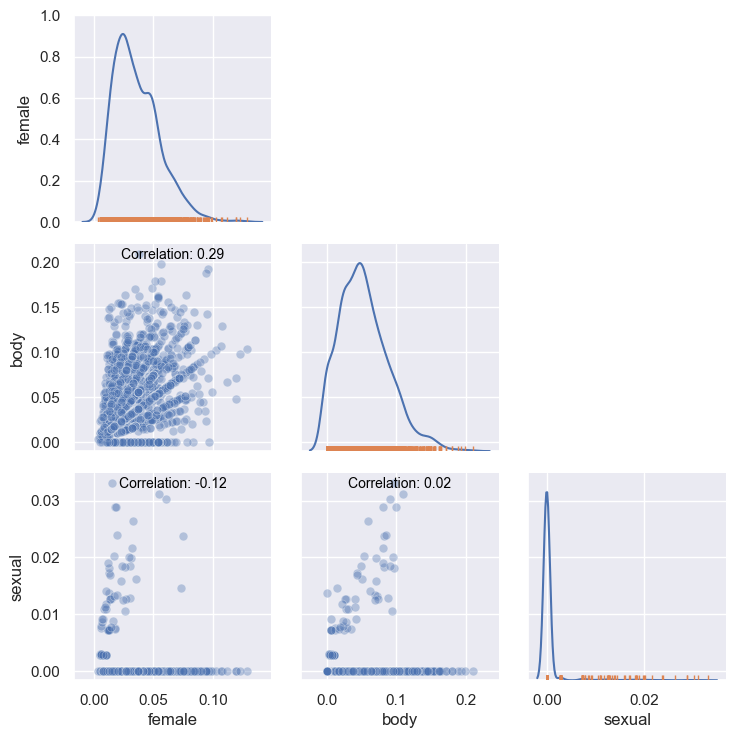

In [8]:
plot_corr_grid(liwc)

# Remark: each dot represents a document/image

# Buen insight para presentación!

C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

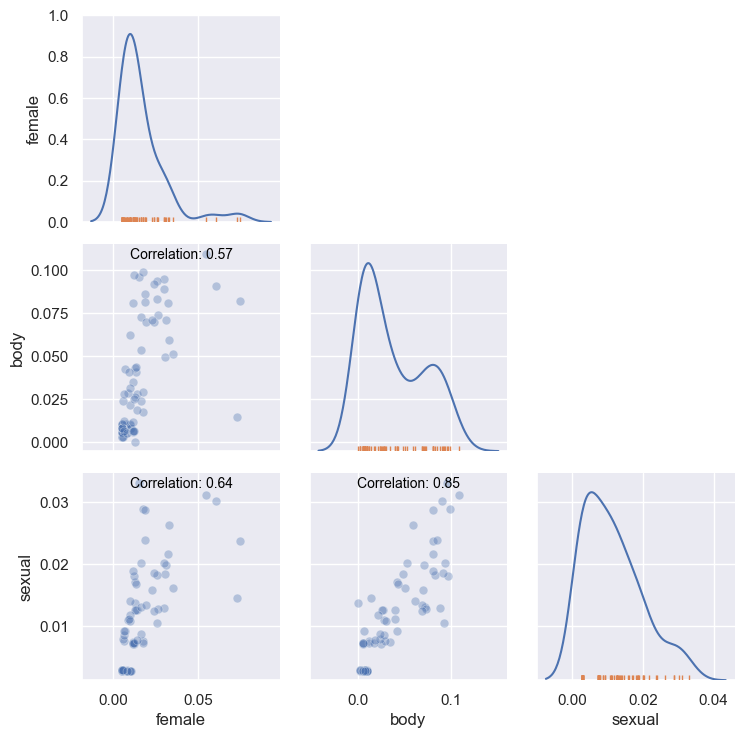

In [9]:
plot_corr_grid(liwc.query("sexual > 0.001"))

## Extra document attributes

C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

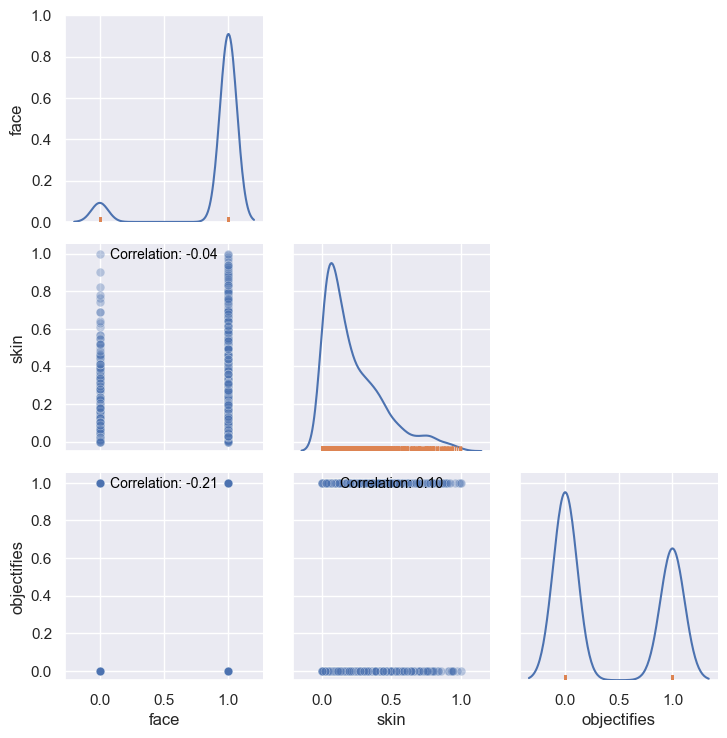

In [10]:
path = os.path.join('..','0_data','gold','8_data_model.xlsx')
with pd.ExcelFile(path) as xl:
    extra_attr = xl.parse() \
    
extra_attr["img_name"] = extra_attr.img_path.apply(os.path.basename)
extra_attr = extra_attr.set_index('img_name') \
                       .drop(columns=['img_path','text_deep_clean'])
    
plot_corr_grid(extra_attr)

# Remark: each dot represents a document/image

## Reading documents and merging data

In [11]:
%%time

text_col = 'text_deep_clean'
path = os.path.join('..','0_data','silver','7_text_clean_large.xlsx')
with pd.ExcelFile(path) as xl:
    data = xl.parse(index_col=0) \
             .set_index('img_name')[['user',text_col]] \
             .drop_duplicates(subset=text_col)

img_dist_users = data.user.value_counts(normalize=True)

join_kwargs = dict(
    on='img_name',
    how='inner',
    validate='1:1'
)
    
data = data.join(liwc, **join_kwargs).join(extra_attr, **join_kwargs)

OHObrands = pd.get_dummies(data.user)
data[OHObrands.columns] = OHObrands
data.drop(columns='user',inplace=True)

CPU times: total: 766 ms
Wall time: 878 ms


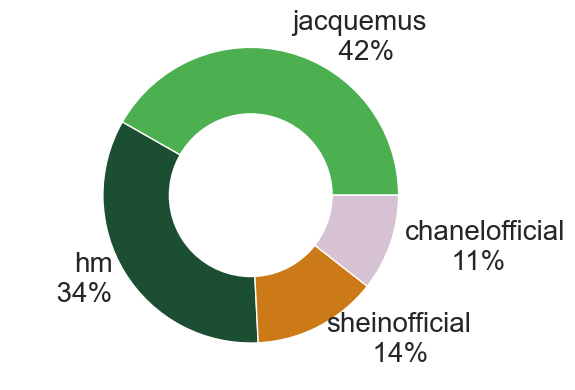

In [12]:
# create data
names = [f"{user}\n      {p:.0%}" for user,p in img_dist_users.items()]
size = img_dist_users.values
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.55, color='white')

# Give color names
colors = ["#4CAF50", "#1C4E33", "#CC7918", "#D6C2D2"]
plt.pie(size, labels=names, colors=colors,textprops={'fontsize': 20})
p = plt.gcf()
p.gca().add_artist(my_circle)

# Show the graph
plt.show()

# Occurrence matrix $M_{wd}$

In [13]:
%%time

documents = data[text_col].values
img_names = data.index.values

words = np.unique([token
                   for doc in documents
                       for token in doc.split()])

words_dict = {wrd:i for i,wrd in enumerate(words)}

CPU times: total: 15.6 ms
Wall time: 23.3 ms


In [14]:
%%time

# occurrence matrix for words
Mwd = csr_matrix((words.size, documents.size), dtype = np.int8)
print(f"Mwd shape: {Mwd.shape}")

for j,doc in tqdm(enumerate(documents)):
    for token in doc.split():
        Mwd[words_dict[token],j] += 1

        
# remove words that are used once or twice
select = np.array(Mwd.sum(axis=1) > 2).flatten()
Mwd = Mwd[select,:]
words = words[select]

# remove documents that do not contain words
select = np.array(Mwd.sum(axis=0) > 0).flatten()
Mwd = Mwd[:,select]
documents = documents[select]
img_names = img_names[select]

print(f"New shape: {Mwd.shape}")

Mwd shape: (2675, 1583)


0it [00:00, ?it/s]C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
1583it [00:26, 60.52it/s]

New shape: (1475, 1583)
CPU times: total: 22.4 s
Wall time: 26.2 s


In [15]:
# Further cleaning and probability matrices computation
Mwd, words, documents, img_names = clean_Mwd_matrix(Mwd,words,documents,img_names)
Pwd, Pww, Pdd, Paa = probability_matrices(Mwd, tform = True)

words_dict = {wrd:i for i,wrd in enumerate(words)}

removing: black blue brown dress foreground front hair hand jacquemus long stand visible wear white woman 


# General overview

## Bipartite Document-Word Network Summary

Number of words: 1460
Number of documents: 1583
Network's gamma is 1.77


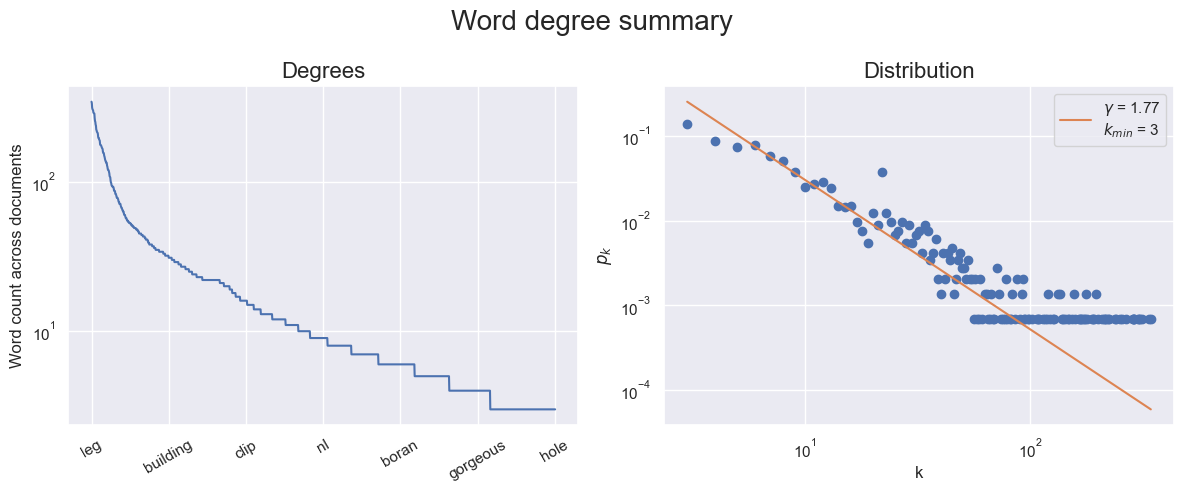

In [16]:
Mwd_df = pd.DataFrame(Mwd.A,index=words,columns=documents)
Pww_df = pd.DataFrame(Pww.A,index=words,columns=words)

gamma, fig, axs = plot_degree_summary(Mwd_df)

## Word scorings

In [17]:
Mwd_df.columns=img_names

norm = pd.DataFrame(np.linalg.inv(np.diag(Mwd_df.sum(axis=1))),
                    index=words,columns=words)

word_scorings = (norm @ Mwd_df @ data.loc[img_names,'female':]).apply(pd.to_numeric)

pr = my_pagerank(Pww)
word_scorings['pagerank'] = pd.Series(pr.flatten(),index=words)

display(word_scorings)
display(word_scorings.describe())

,female,body,sexual,face,skin,objectifies,chanelofficial,hm,jacquemus,sheinofficial,pagerank
abandon,0.023159,0.056248,0.000000,0.750000,0.268871,0.000000,1.000000,0.000000,0.000000,0.000000,0.150039
absence,0.006676,0.007130,0.002855,1.000000,0.258281,0.136364,0.000000,0.000000,1.000000,0.000000,0.150013
accessible,0.020260,0.021345,0.000000,1.000000,0.073243,0.000000,0.000000,1.000000,0.000000,0.000000,0.150022
accessorize,0.036038,0.044145,0.000543,0.978723,0.197491,0.388298,0.085106,0.265957,0.276596,0.372340,0.150571
accessory,0.031705,0.068706,0.002367,0.642857,0.453137,0.357143,0.071429,0.357143,0.428571,0.142857,0.150096
...,...,...,...,...,...,...,...,...,...,...,...
zifeng,0.016450,0.012790,0.000000,1.000000,0.177738,0.000000,1.000000,0.000000,0.000000,0.000000,0.150021
zip,0.032172,0.070723,0.000000,1.000000,0.240495,0.000000,0.000000,1.000000,0.000000,0.000000,0.150029
zipper,0.040232,0.072967,0.000000,1.000000,0.109804,0.166667,0.000000,0.750000,0.166667,0.083333,0.150076
zoe,0.044617,0.029263,0.000000,1.000000,0.083710,0.700000,0.000000,0.000000,1.000000,0.000000,0.150071


,female,body,sexual,face,skin,objectifies,chanelofficial,hm,jacquemus,sheinofficial,pagerank
count,1460.000000,1460.000000,1460.000000,1460.000000,1.460000e+03,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,0.027183,0.044655,0.001129,0.929048,2.478459e-01,0.309308,0.276886,0.316082,0.292092,0.114940,0.150087
std,0.012423,0.023484,0.002329,0.134040,1.326951e-01,0.256411,0.378521,0.384923,0.389421,0.252675,0.000125
min,0.006676,0.000000,0.000000,0.000000,3.436993e-07,0.000000,0.000000,0.000000,0.000000,0.000000,0.150004
25%,0.018686,0.028130,0.000000,0.909091,1.537896e-01,0.125000,0.000000,0.000000,0.000000,0.000000,0.150024
50%,0.025711,0.042231,0.000000,1.000000,2.327662e-01,0.272727,0.046077,0.106763,0.000000,0.000000,0.150043
75%,0.033769,0.059944,0.001528,1.000000,3.169363e-01,0.461538,0.500000,0.636364,0.600000,0.079315,0.150092
max,0.080520,0.148922,0.023091,1.000000,8.779384e-01,1.000000,1.000000,1.000000,1.000000,1.000000,0.150910


C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

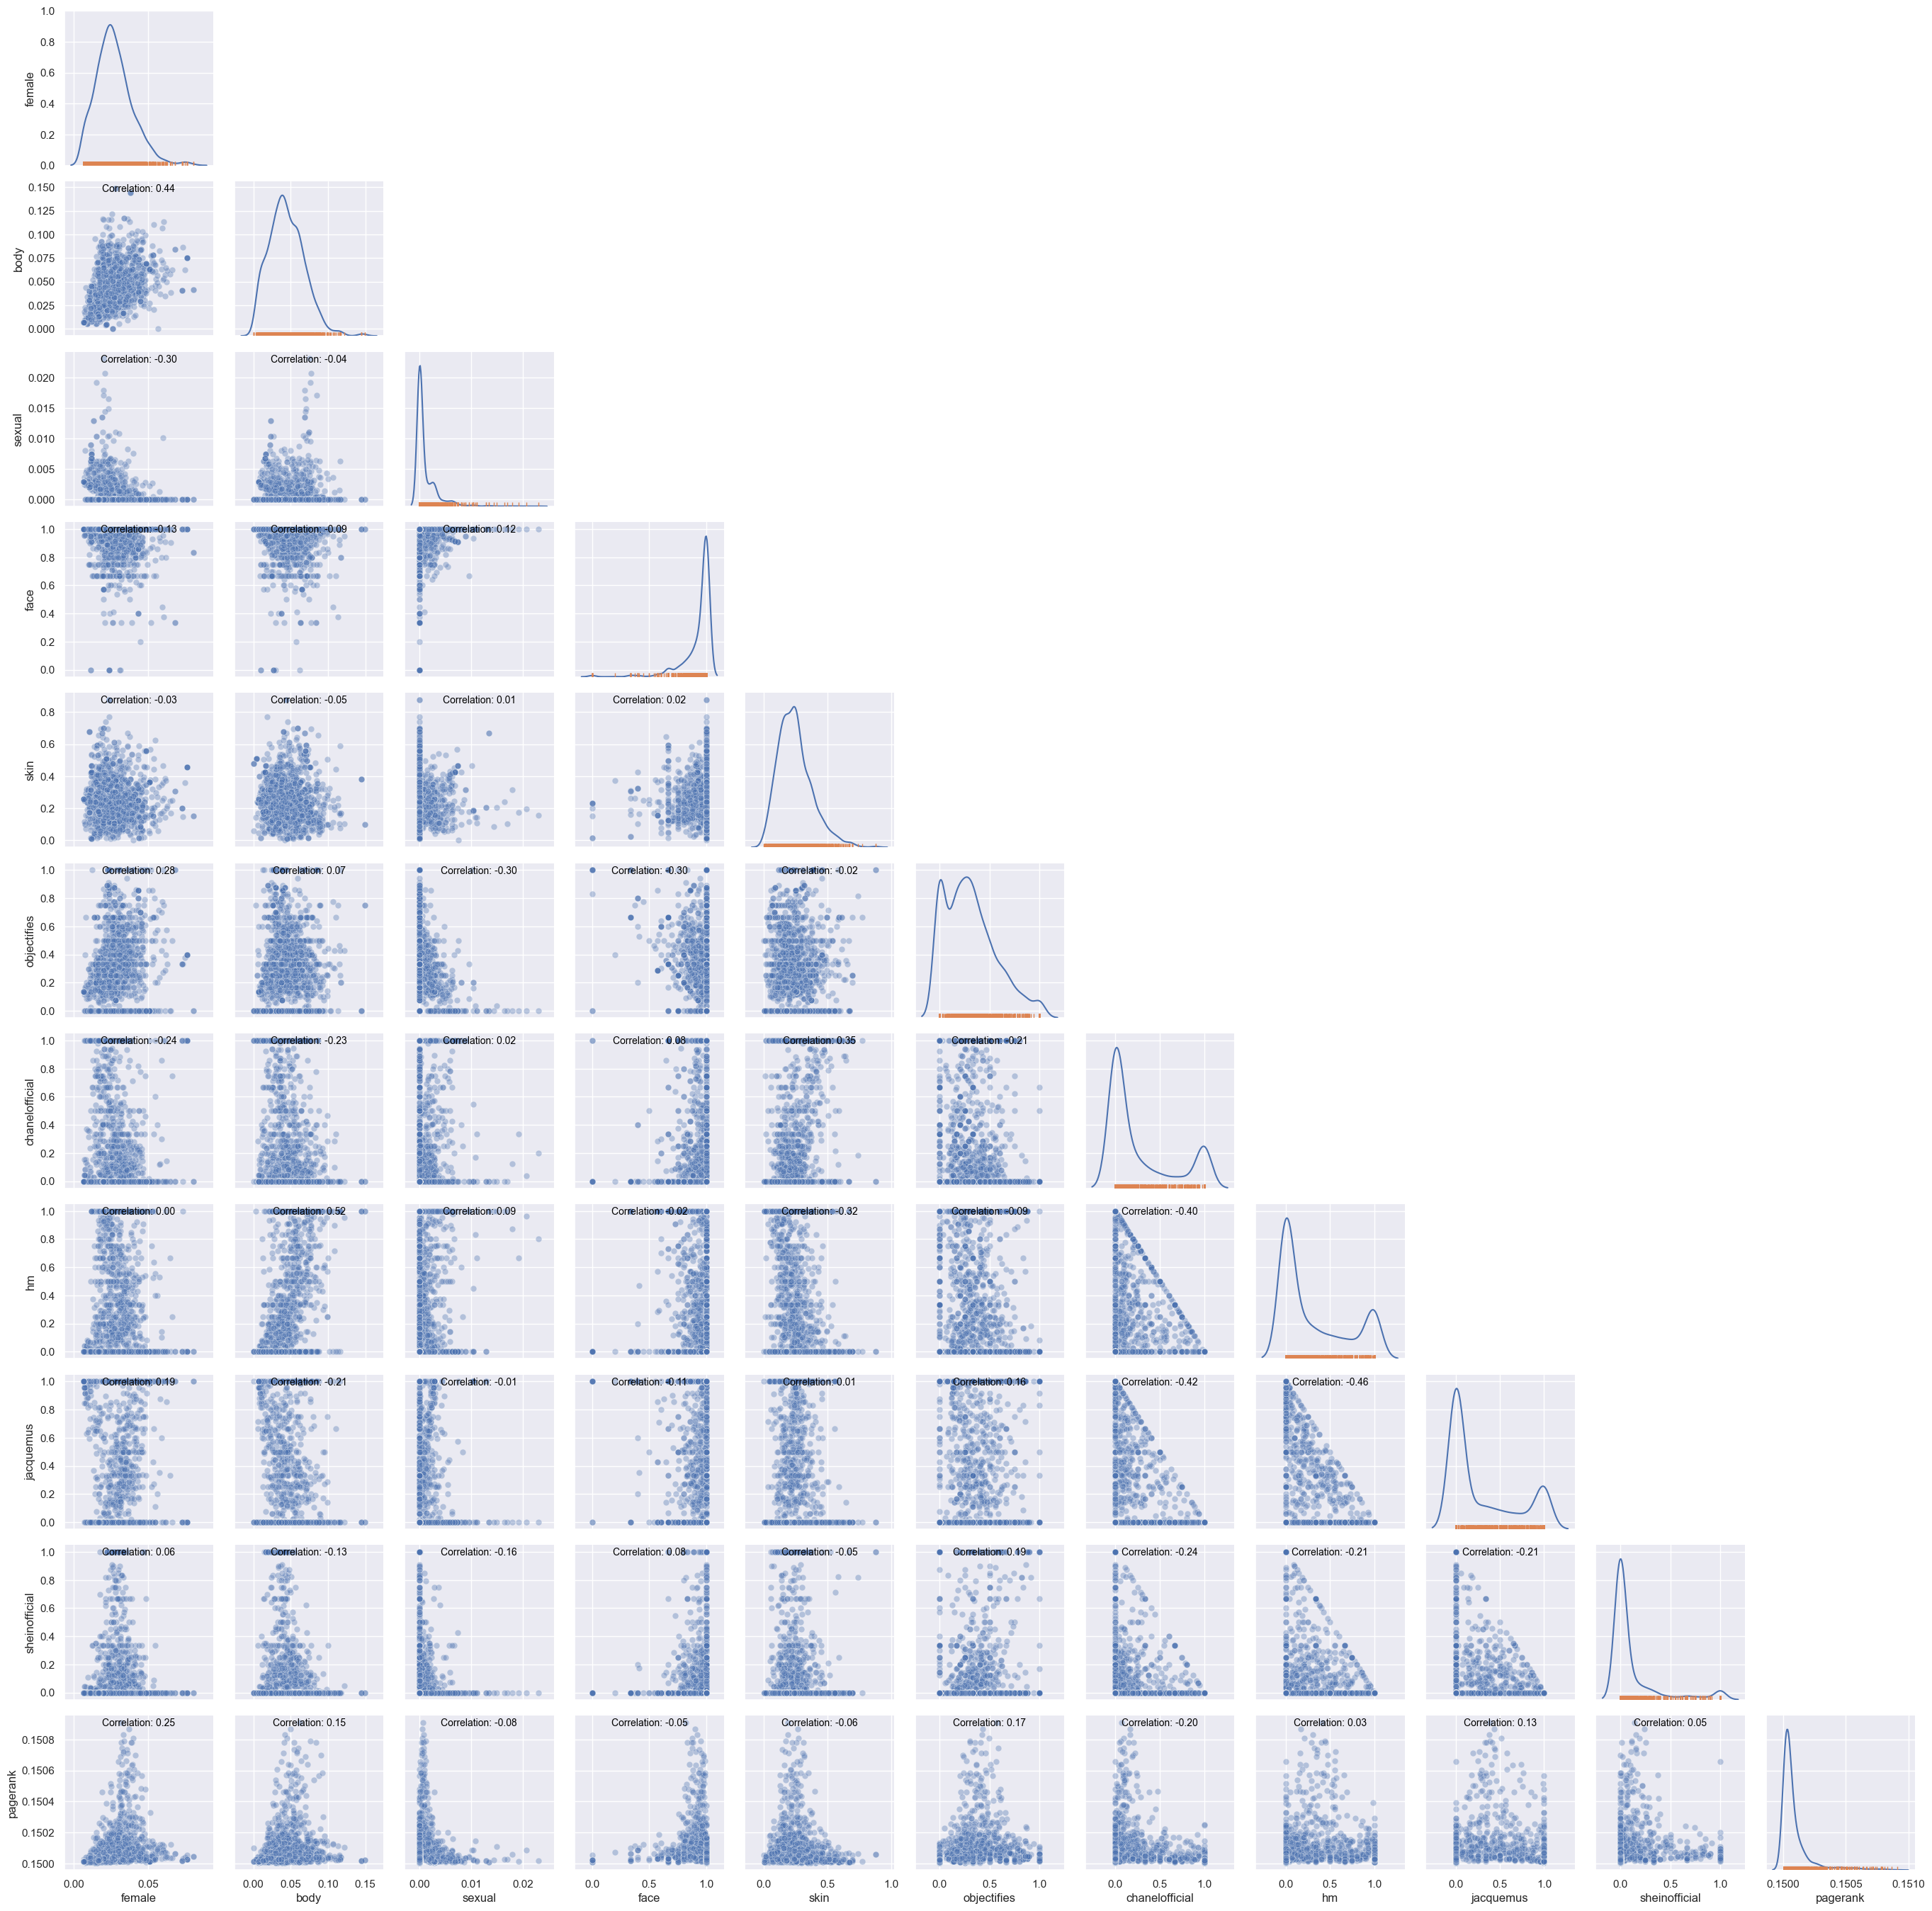

In [18]:
plot_corr_grid(word_scorings)

# Remark: each dot represents a word

## Links' weight distribution

C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Weight', ylabel='Density'>

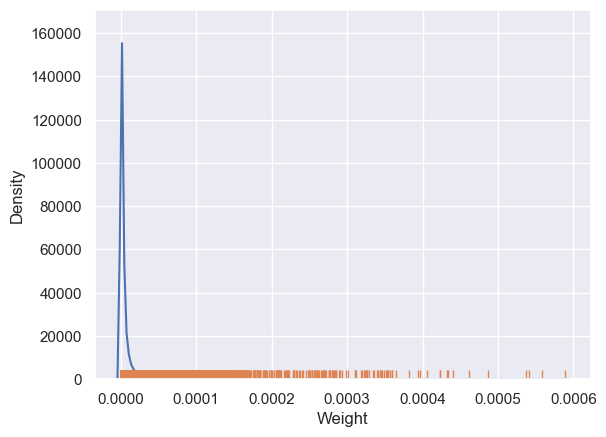

In [19]:
links = Pww_df.where((np.triu(np.ones(Pww_df.shape))).astype(np.bool_)) \
              .melt(ignore_index=False, var_name='Target', value_name='Weight') \
              .dropna() \
              .query("""Weight !=0""") \
              .reset_index() \
              .rename(columns={'index':'Source'})

sns.kdeplot(data=links, x='Weight')
sns.rugplot(data=links, x='Weight')

## Homophily / Assortativity analysis

In [20]:
%%time
G_nx = nx.from_pandas_edgelist(links, 'Source', 'Target', ['Weight'],create_using=nx.Graph())

assortativity_dict = dict()
use_weight_flag = True

for var in word_scorings.columns:
    assortativity_dict[var] = []
    print(var)
    
    for i in tqdm(G_nx):
        for j in G_nx.neighbors(i):
            
            node_val = word_scorings.loc[i,var]
            neighbor_val = word_scorings.loc[j,var]

            assortativity_dict[var].append((node_val, neighbor_val))

for var,dist in assortativity_dict.items():
#     assortativity_dict[var] = pd.DataFrame(dist, columns=['node_val','neighbors_val','w_neighbors_val'])
    assortativity_dict[var] = pd.DataFrame(dist, columns=['node_val','neighbors_val'])

female


100%|█████████████████████████████████████████████████████████████████████████████| 1460/1460 [00:04<00:00, 312.62it/s]


body


100%|█████████████████████████████████████████████████████████████████████████████| 1460/1460 [00:04<00:00, 317.88it/s]


sexual


100%|█████████████████████████████████████████████████████████████████████████████| 1460/1460 [00:04<00:00, 317.71it/s]


face


100%|█████████████████████████████████████████████████████████████████████████████| 1460/1460 [00:04<00:00, 318.64it/s]


skin


100%|█████████████████████████████████████████████████████████████████████████████| 1460/1460 [00:04<00:00, 294.34it/s]


objectifies


100%|█████████████████████████████████████████████████████████████████████████████| 1460/1460 [00:04<00:00, 303.83it/s]


chanelofficial


100%|█████████████████████████████████████████████████████████████████████████████| 1460/1460 [00:04<00:00, 320.02it/s]


hm


100%|█████████████████████████████████████████████████████████████████████████████| 1460/1460 [00:04<00:00, 325.29it/s]


jacquemus


100%|█████████████████████████████████████████████████████████████████████████████| 1460/1460 [00:04<00:00, 315.31it/s]


sheinofficial


100%|█████████████████████████████████████████████████████████████████████████████| 1460/1460 [00:04<00:00, 316.41it/s]


pagerank


100%|█████████████████████████████████████████████████████████████████████████████| 1460/1460 [00:04<00:00, 302.97it/s]


CPU times: total: 32 s
Wall time: 52.5 s


C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in 

CPU times: total: 5.75 s
Wall time: 6.21 s


Text(0.5, 1.02, 'Assortativity analysis')

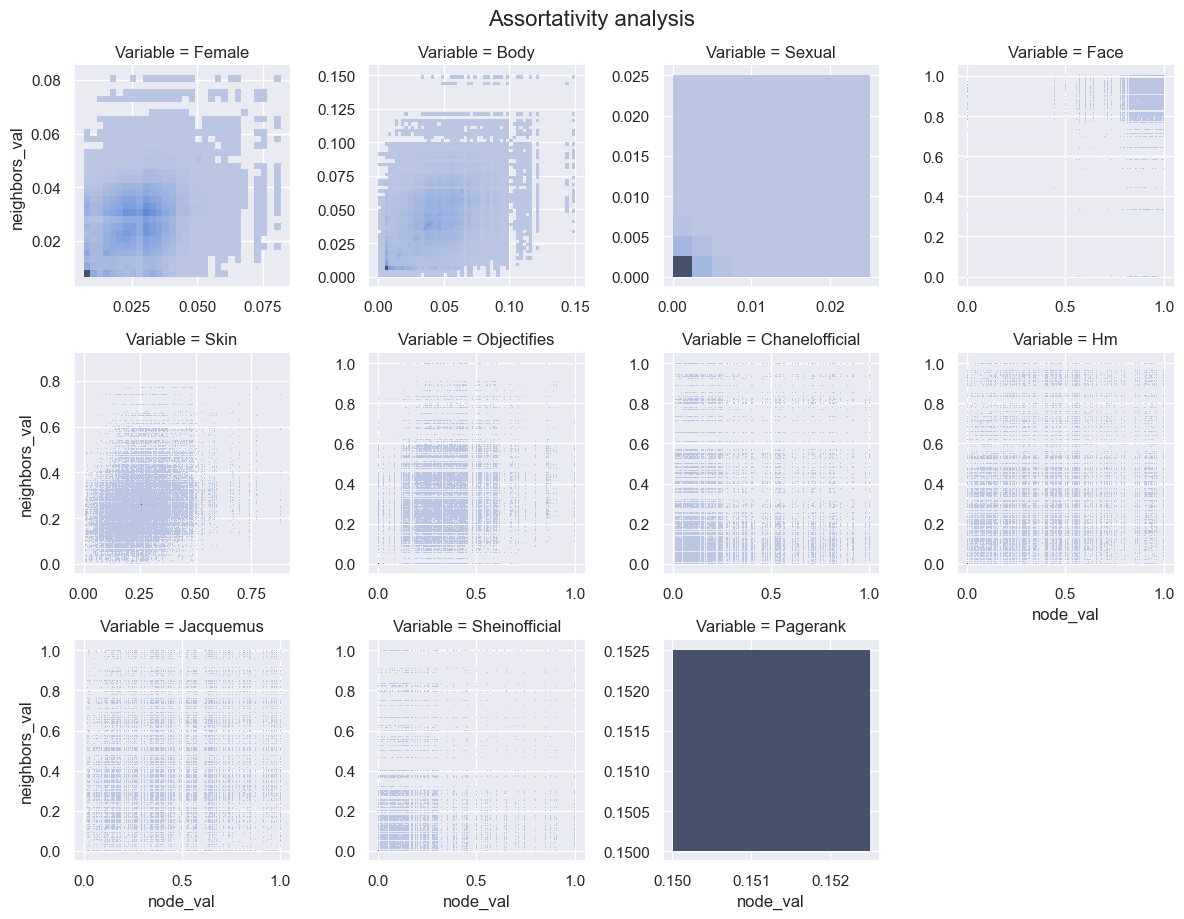

In [21]:
%%time


df = pd.concat([df.eval(f"Variable = '{name.title()}'",engine='python')
                for name,df in assortativity_dict.items()])

w = 0.0025
g = sns.FacetGrid(df, col='Variable', col_wrap=4, sharex=False, sharey=False)
g.map(sns.histplot, "node_val", "neighbors_val", binwidth=(w,w))
plt.suptitle("Assortativity analysis", y=1.02, fontsize=16)

## Output for Gephi

In [22]:
tag = "every_document"

links.to_csv(f'data/processed/{tag}__links_v2.csv',
                  encoding='UTF-16',index=False)


# Writing nodes
wrds = np.unique(links.Source.tolist() + links.Target.tolist())

first_cols = ['Id','Label']
nodes = word_scorings.loc[wrds,:] \
                     .sort_index() \
                     .reset_index(names='Id') \
                     .eval("Label=Id",engine='python') \
                     .rename(columns={'pagerank':'python_pagerank'})
nodes = nodes[first_cols + [col for col in nodes if col not in first_cols]]
nodes.to_csv(f'data/processed/{tag}__nodes_v2.csv',encoding='UTF-16',index=False)

# Community assignment

In [23]:
partitions = dict()

# function to map the partition into a community assignment matrix C
# where rows represent documents, and columns represent topics
def partition_to_C(part):
    
    with warnings.catch_warnings(record=True) as w:    
        C = sps.csr_matrix((Pww.shape[0],len(part)))
        for community,nodes in enumerate(part):
            C[np.array(nodes), community] = 1
    return C

def modularity(C, A_0):
    if C.shape[0] > C.shape[1]:
        C = C.T.copy()
    
    d_0 = A_0.sum()
    A = A_0/d_0
    d = A.sum(axis=1)

    Q = (C @ ( A - d@d.T ) @ C.T).diagonal().sum()
    
    return Q


def register_partition(name,C,Pww,Pwd,partitions):
    
    partitions[name] = dict()
    partitions[name]['C'] = C
    partitions[name]['Q'] = modularity(C,Pww.copy())
    partitions[name]['Ncut'] = ncut_function(C.T @ Pww @ C)
    partitions[name]['NMI'] = nmi_function(Pwd.T @ C)
    
    with warnings.catch_warnings(record=True) as w:
        r = infomap_rank(Pww)
        partitions[name]['infomap'] = infomap(C,Pww,r)

    print(f"{name}:")
    print(f"\tModularity: {partitions[name]['Q']:.2%}")
    print(f"\tN-cut: {partitions[name]['Ncut']:.2%}")
    print(f"\tNMI: {partitions[name]['NMI']:.2%}")
    print(f"\tInfomap: {partitions[name]['infomap']:.2%}")
    print(f"\n\tShape of matrix C: {C.shape}")

In [24]:
def infomap_function(v):
    y = -(v.data*logg(v.data/v.sum())).sum()
    return y


def infomap_rank(Pdd):
    # transition matrix
    pd = Pdd.sum(axis=0).flatten()
    M = sps.csr_matrix(Pdd/pd)
    
    # pagerank vector - faster than r = my_pagerank(M,q)
    G = ig.Graph.Adjacency((M > 0).toarray().tolist())
    G.es['weight'] = np.array(M[M.nonzero()])[0]
    r = G.pagerank(weights='weight')
    r = (sps.csr_matrix(np.array(r))).T

    return r


def infomap(C,Pdd,r):
    pd = Pdd.sum(axis=0).flatten()
    M = Pdd/pd # transition matrix
    
    # extract vectors
    z = C.T*sps.diags(r.toarray().flatten())
    q = sps.csr_matrix((1,z.shape[0]))
    c = 0.85
    
    for i in range(z.shape[0]):
        tmp = (C[:,i].transpose() * M) * z[i].transpose()
        q[0,i] = (1 - (1-c)*C[:,i].sum()/M.shape[0]) * z[i].sum() - c*tmp[0,0]
    
    # extract statistics
    y = infomap_function(q)
    
    for i in range(z.shape[0]):
        y += infomap_function(sps.hstack([z[i],sps.csr_matrix([[q[0,i]]])]))
    
    # normalize
    y = (y/infomap_function(pd))-1

    return y

## Louvain

In [25]:
A = sps.csr_matrix(Pww)
G = ig.Graph.Adjacency((A > 0).toarray().tolist())
G.es['weight'] = np.array(A[A.nonzero()])[0]

In [26]:
%%time
part = louvain.find_partition(G, louvain.ModularityVertexPartition,
                                 weights='weight', seed=42)
# 
C_l = partition_to_C(part)

register_partition('louvain',C_l,Pww,Pwd,partitions)

louvain:
	Modularity: 33.88%
	N-cut: 54.37%
	NMI: 51.71%
	Infomap: 7.08%

	Shape of matrix C: (1460, 14)
CPU times: total: 1.7 s
Wall time: 834 ms


## Soft Louvain

In [27]:
%%time

# refine with soft Louvain

with warnings.catch_warnings(record=True) as w:
    C_sl, _A, _Q = my_soft_louvain(Pww.copy(), partitions['louvain']['C'].copy(),seed=42)
    
register_partition('soft_louvain',C_sl,Pww,Pwd,partitions)

soft_louvain:
	Modularity: 34.37%
	N-cut: 55.29%
	NMI: 52.02%
	Infomap: 7.01%

	Shape of matrix C: (1460, 13)
CPU times: total: 5.11 s
Wall time: 4.46 s


## Infomap

In [28]:
%%time
infomap_clusters = G.community_infomap(edge_weights=G.es["weight"])
C_im = partition_to_C(infomap_clusters)

register_partition('infomap',C_im,Pww,Pwd,partitions)

infomap:
	Modularity: 6.78%
	N-cut: 48.55%
	NMI: 74.33%
	Infomap: 4.95%

	Shape of matrix C: (1460, 21)
CPU times: total: 5.48 s
Wall time: 4.92 s


## BigCLAM

In [29]:
def sigm(x):
    return np.divide(np.exp(-1.*x),1.-np.exp(-1.*x))

def log_likelihood(F, A):
    """implements equation 2 of 
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf"""
    A_soft = F.dot(F.T)

    # Next two lines are multiplied with the adjacency matrix, A
    # A is a {0,1} matrix, so we zero out all elements not contributing to the sum
    FIRST_PART = A*np.log(1.-np.exp(-1.*A_soft))
    sum_edges = np.sum(FIRST_PART)
    SECOND_PART = (1-A)*A_soft
    sum_nedges = np.sum(SECOND_PART)

    log_likeli = sum_edges - sum_nedges
    return log_likeli

def gradient(F, A, i):
    """Implements equation 3 of
    https://cs.stanford.edu/people/jure/pubs/bigclam-wsdm13.pdf
    
      * i indicates the row under consideration
    
    The many forloops in this function can be optimized, but for
    educational purposes we write them out clearly
    """
    N, C = F.shape

    neighbours = np.where(A[i])
    nneighbours = np.where(1-A[i])

    sum_neigh = np.zeros((C,))
    for nb in neighbours[0]:
        dotproduct = F[nb].dot(F[i])
        sum_neigh += F[nb]*sigm(dotproduct)

    sum_nneigh = np.zeros((C,))
    #Speed up this computation using eq.4
    for nnb in nneighbours[0]:
        sum_nneigh += F[nnb]

    grad = sum_neigh - sum_nneigh
    return grad



def train(A, C, iterations = 100, initial_F=None):
    # initialize an F
    N = A.shape[0]
    F = np.random.rand(N,C) if initial_F is not None else initial_F

    for n in range(iterations):
        for person in range(N):
            grad = gradient(F, A, person)

            F[person] += 0.0025*grad

            F[person] = np.maximum(0.001, F[person]) # F should be nonnegative
        ll = log_likelihood(F, A)
        print('At step %5i/%5i ll is %5.3f'%(n, iterations, ll))
    return F

In [30]:
%%time
F = train(Pww.A, C_sl.shape[1], iterations=30, initial_F=C_sl)
F_argmax = np.argmax(F,1)

F_norm = np.diag(1/F.sum(axis=1)) @ F

register_partition('BigCLAM',csr_matrix(F_norm),Pww,Pwd,partitions)

At step     0/   30 ll is -148838.579
At step     1/   30 ll is -1323733049.155
At step     2/   30 ll is -2134451061.598
At step     3/   30 ll is -609423316.551
At step     4/   30 ll is -850513997.143
At step     5/   30 ll is -867232857.074
At step     6/   30 ll is -640579417.651
At step     7/   30 ll is -460905963.030
At step     8/   30 ll is -392524338.816
At step     9/   30 ll is -400309282.414
At step    10/   30 ll is -358903399.230
At step    11/   30 ll is -394325284.856
At step    12/   30 ll is -423445732.478
At step    13/   30 ll is -357556936.823
At step    14/   30 ll is -353943377.558
At step    15/   30 ll is -310646715.463
At step    16/   30 ll is -277151376.948
At step    17/   30 ll is -275675748.036
At step    18/   30 ll is -292491156.748
At step    19/   30 ll is -378801038.121
At step    20/   30 ll is -353849158.551
At step    21/   30 ll is -350131787.553
At step    22/   30 ll is -336094108.180
At step    23/   30 ll is -318725819.218
At step    24/   

## Clustering Comparison

C:\Users\danie\anaconda3\envs\ds_master\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


Text(0.5, 1.0, 'Clusterization agreement among algorithms (NMI)')

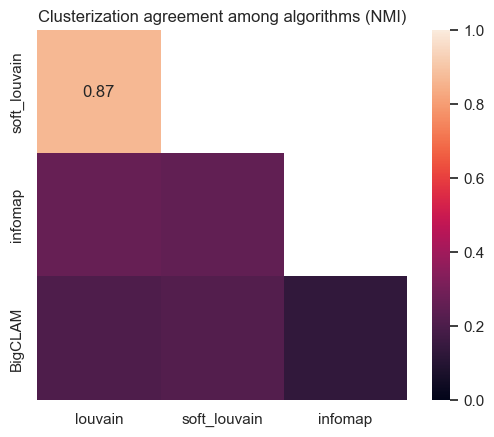

In [31]:
algos = list(partitions.keys())

nmi_algos = []

for k,alg_k in enumerate(algos):
    for alg_l in algos[k:]:
        
        C_k = partitions[alg_k]['C']
        C_l = partitions[alg_l]['C']

        c_k = np.argmax(C_k.A,axis=1)
        c_l = np.argmax(C_l.A,axis=1)
        
        nmi_kl = normalized_mutual_info_score(c_k,c_l)
        
        nmi_algos.append((alg_k,alg_l,nmi_kl))
        
nmi_df = pd.DataFrame(nmi_algos,columns=['algo_1','algo_2','NMI']).set_index(['algo_1','algo_2']).unstack()
nmi_df = pd.DataFrame(nmi_df.fillna(0).values + nmi_df.fillna(0).T.values - 2*np.identity(len(algos)),
                      columns=[t[1] for t in nmi_df.columns.values], index=nmi_df.index.values) \
           .loc[algos[1:],algos[:-1]]


sns.set_context('talk')
up_triang = ~np.tril(np.ones_like(nmi_df).astype(bool))
sns.set_theme(style='white')
sns.heatmap(nmi_df,vmin=0,vmax=1,annot=True,square=True,mask=up_triang) \
   .set_title("Clusterization agreement among algorithms (NMI)")

## Statistical analysis of community detection results

In [32]:
n_comm = partitions['louvain']['C'].shape[1]
word_scorings['louvain_cluster'] = partitions['louvain']['C'] @ np.array(range(n_comm))[:,np.newaxis]
# word_scorings.to_excel(f'data/processed/{tag}__word_scorings_v2.xlsx')

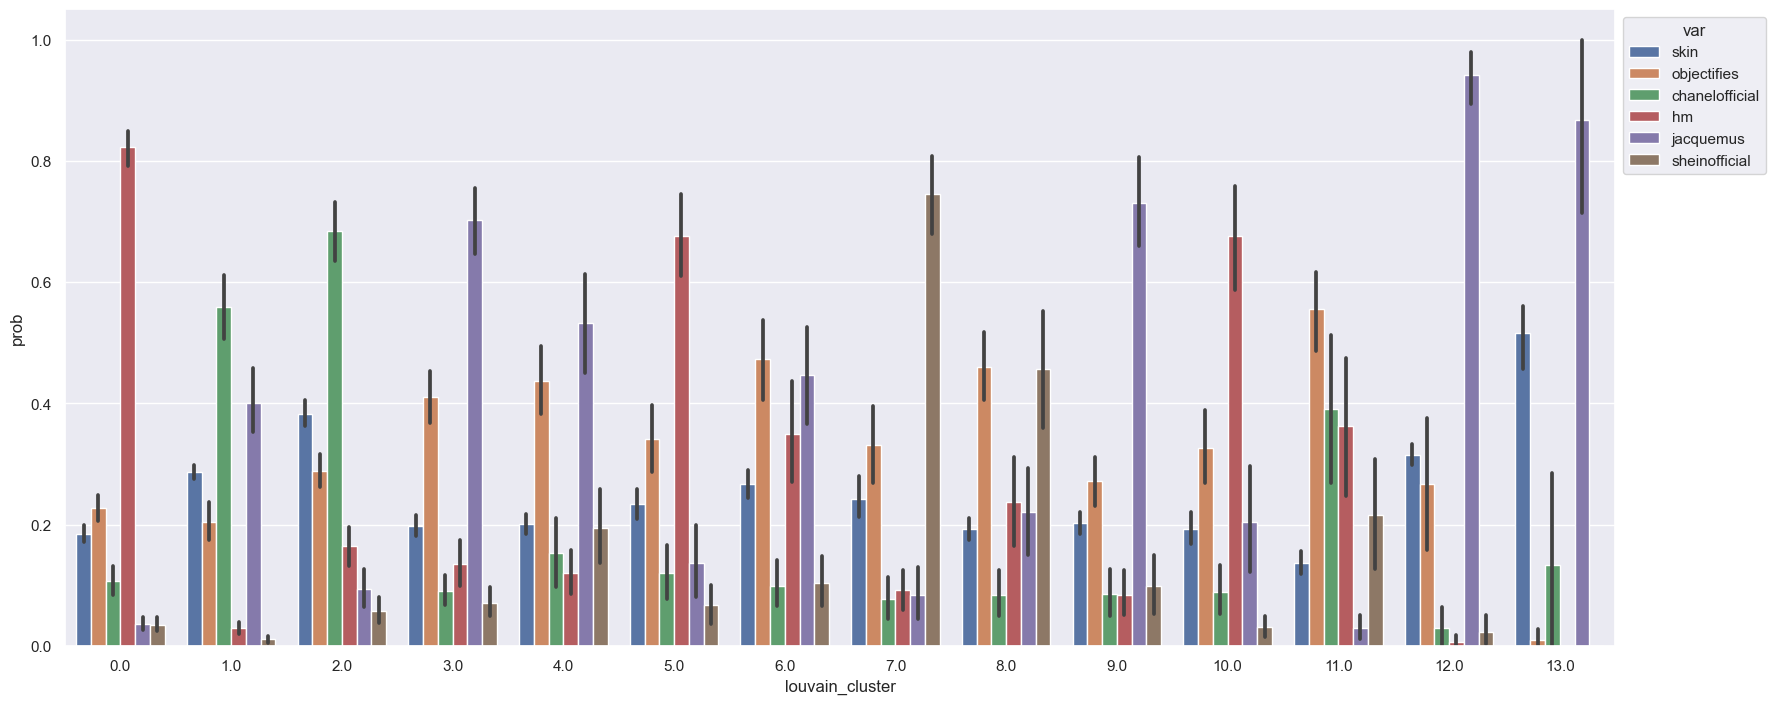

In [33]:
q = word_scorings.loc[:,'female':] \
                 .drop(columns=['pagerank','face','sexual','female','body']) \
                 .set_index('louvain_cluster') \
                 .stack() \
                 .to_frame() \
                 .reset_index() \
                 .rename(columns={'level_1':'var',0:'prob'})

sns.set(rc={'figure.figsize':(20,8.27)})
ax = sns.barplot(x="louvain_cluster", y="prob", hue="var", data=q)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

In [34]:
x_luxury = data.query("chanelofficial or jacquemus")['objectifies']
x_cheap = data.query("~(chanelofficial or jacquemus)")['objectifies']
x = data['objectifies']

se = np.sqrt( x.mean()*(1-x.mean()) * (1/x_luxury.size + 1/x_cheap.size) )
t = (x_luxury.mean() - x_cheap.mean()) / se

print(f"Luxury: {x_luxury.mean():.2%} +- {x_luxury.std()/np.sqrt(x_luxury.size):.2%}")
print(f"Cheap: {x_cheap.mean():.2%} +- {x_cheap.std()/np.sqrt(x_luxury.size):.2%}")
print(f"T-test (H_0 = means are equal): {t:.4f}")

st.ttest_ind(x_luxury, x_cheap, equal_var=False)

# There is enough evidence to discard the null hypothesis:
# the means are indeed different

Luxury: 44.93% +- 1.73%
Cheap: 36.95% +- 1.68%
T-test (H_0 = means are equal): 3.2203


TtestResult(statistic=3.233369613719913, pvalue=0.0012487241092735653, df=1574.875382203076)

In [35]:
# https://www.r-bloggers.com/2020/10/hotellings-t2-in-julia-python-and-r/

def TwoSampleT2Test(X, Y):
    nx, p = X.shape
    ny, _ = Y.shape
    
    delta = np.mean(X, axis=0) - np.mean(Y, axis=0)
    Sx = np.cov(X, rowvar=False)
    Sy = np.cov(Y, rowvar=False)
    
    S_pooled = ((nx-1)*Sx + (ny-1)*Sy)/(nx+ny-2)
    t_squared = (nx*ny)/(nx+ny) * delta.T @ np.linalg.inv(S_pooled) @ delta
    
    statistic = t_squared * (nx+ny-p-1)/(p*(nx+ny-2))
    F = st.f(p, nx+ny-p-1)
    p_value = 1 - F.cdf(statistic)
    
    return statistic, p_value

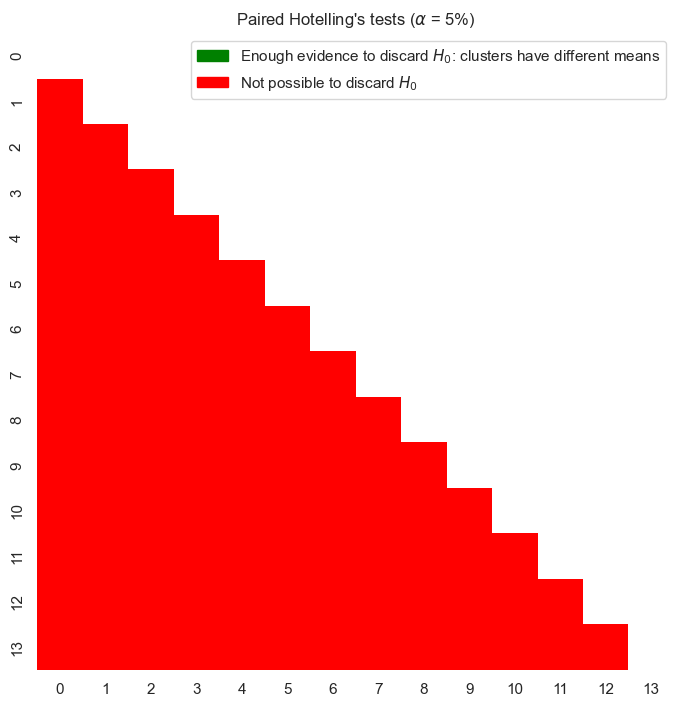

In [36]:
n_clusters = int(word_scorings.louvain_cluster.max()) + 1
clusters = range(n_clusters)

p_values = np.empty((n_clusters,n_clusters))
p_values[:] = np.nan

for i in clusters:
    for j in clusters[:i]:
        
        X = word_scorings.query("louvain_cluster == @i").iloc[:,:-1].values
        Y = word_scorings.query("louvain_cluster == @j").iloc[:,:-1].values
        
        p_values[i,j] = TwoSampleT2Test(X,Y)[1] < 0.05
        

colors = ['red', 'green']

up_triang = ~np.tril(np.ones_like(p_values).astype(bool))
sns.set_theme(style='white')
sns.heatmap(p_values, square=True,mask=up_triang, cmap=colors, cbar=False)
plt.title(r"Paired Hotelling's tests ($\alpha$ = 5%)")

legend_labels = [r'Not possible to discard $H_0$', 'Enough evidence to discard $H_0$: clusters have different means']
legend_patches = [mpatches.Patch(color=color, label=label) for color, label in zip(colors, legend_labels)][::-1]
plt.legend(handles=legend_patches, loc='upper right')

# Google's Gemini

In [37]:
gephi_word_scorings = pd.read_csv('gephi_data.csv') \
                        .set_index("Id") \
                        [word_scorings.columns.difference(['pagerank', 'louvain_cluster']).tolist() + ['modularity_class']]

In [38]:
import google.generativeai as genai
import textwrap
from IPython.display import display, Markdown

def to_markdown(text):
    text = text.replace('•', '  *')
    return Markdown(textwrap.indent(text, '> ', predicate=lambda _: True))

api_path = os.path.join('..','..','..','MSc DS','Network Science','Project','gemini_api.txt')
with open(api_path,'r') as f:
    GOOGLE_API_KEY = f.read().strip()
    
genai.configure(api_key = GOOGLE_API_KEY)
model = genai.GenerativeModel('gemini-pro')

context = ("Hey Gemini! Nice to see you. I'm working on a data science project which tries to " +
           "identify objectification of women in marketing campaigns of clothing brands on Instagram. " +
           "The brands being analyzed are Jacquemus, Channel, H&M, and Shein. We basically take their " +
           "posts and compute semantic networks, which are networks that relate the words usedbased on " +
           "how often they are used together. After that, we run the Louvain community detection algorithm " +
           "to find clusters of words that are more closely related. Our hypothesis is that each community " +
           "hold a semantic meaning. Could you help us identify what are the following words refering to? " +
           "Please be concise and give at most 3 concepts that fully summarize the following list of words:")

ModuleNotFoundError: No module named 'google.generativeai'

In [41]:
%%time
l = []
for k in gephi_word_scorings.modularity_class.sort_values().unique():
    print(f"Cluster {k}:")
    
    df = gephi_word_scorings.query(f'modularity_class=={k}')
    
    prompt = context+'-'+'\n-'.join(df.index.tolist())
    response = model.generate_content(prompt)
    
    print("\Gemini's response:")
    display(to_markdown(response.text))
    
    print("\nSample of words:")
    print(', '.join(gephi_word_scorings.sample(20).index.tolist()))
    
    l.append(response)
    print('-'*150)

Cluster 0:
\Gemini's response:


> - **Fashion and clothing**: accompany, adorn, athleisure, backdrop, campaign, caption, collaboration, costume, destination, fashion, finish, gear, hoodie, lookbook, magazine, model, outfit, photo, preview, project, runway, shoot, style, trend, wardrobe.
> 
> 
> - **Places and settings**: area, beach, bed, building, campagne, carpet, chair, couch, field, garden, home, hotel, house, island, landscape, location, mansion, mirror, mountain, museum, park, path, pool, room, sea, sky, street, studio, town, villa.
> 
> 
> - **Emotions and feelings**: calm, crazy, happy, inspire, intimate, love, merry, obsessed, passion, pleasure, relax, sensual, sexy, special, unique, wonderful.


Sample of words:
mule, france, come, shade, patent, chandelier, sock, d, skin, gold, wonder, few, headband, many, carpet, colour, byzantin, pocket, standard, decide
------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster 1:
\Gemini's response:


> - **Fashion**: bench, bracelet, decorate, disguise, glow, grab, serve, shine, sparkle, szn
> - **Relationships**: boy, child, couple, cry, dance, love, laugh, listen
> - **Places**: foret, sydney, supermarket, hawai, daytime, midnight, daytime


Sample of words:
recreate, slouchy, stunning, tall, element, artwork, pleat, lame, decision, pant, photograph, com, le, calm, forever, cross, inspiration, commercial, collectively, motivate
------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster 2:
\Gemini's response:


> - **Fashion and beauty industry:** Words like "accessory," "beauty," "fashion," "makeup," and "jewelry" suggest a focus on personal style, appearance, and the products used to achieve them.
> 
> 
> - **Luxury and exclusivity:** Terms like "exclusive," "sophisticated,"  "precious," and "luxury" imply a sense of elegance, refinement, and prestige associated with high-end brands and products.
> 
> 
> - **Femininity and empowerment:** Words like "feminine," "sensual," "powerful," and "confident" hint at themes of female empowerment, self-expression, and the celebration of femininity.


Sample of words:
rock, helmet, obsess, tom, bright, vibe, pre, inspire, match, reflection, sort, chan, welcome, warmer, flower, morning, silky, sweatshirt, sleepwear, spend
------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster 3:
\Gemini's response:


> 1. **Fashion and Style**:
>    - Luxury
>    - Minimalism
>    - Fashion
>    - Quality
> 
> 
> 2. **Places and Locations**:
>    - London
>    - Stockholm
>    - South
>    - Palais
> 
> 
> 3. **Events and Occasions**:
>    - Christmas
>    - Holiday
>    - September
>    - Awards


Sample of words:
waterhouse, kursturica, mouth, oval, foret, sensual, bauble, cocktail, journey, tank, racket, bucket, jamie, extra, part, cross, yet, corona, microphone, little
------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster 4:
\Gemini's response:


> - **Fashion**: clothing, accessories, styles.
> - **Celebrities and Influencers**: public figures associated with fashion, endorsements, collaborations.
> - **Product Features**: colors, materials, shapes, patterns.


Sample of words:
mesh, evening, innovative, make, check, fact, glimpse, few, intense, magic, magical, most, pocket, scent, tomorrow, chic, young, print, tram, gay
------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster 5:
\Gemini's response:


> 1. Film and Cinema: This cluster includes words such as "film", "cinema", "actress", "actor", "director", and "screen". It refers to the use of celebrities and the world of cinema in marketing campaigns.
> 2. Fashion and Style: This cluster includes words such as "fashion", "style", "designer," "collection", "clothing", and "brand". This cluster focuses on describing the brand's fashion products and collections.
> 3. Luxury and Exclusivity: This cluster includes words like "luxury," "exclusive," "high-end," "sophisticated," and "designer". It highlights the luxurious and high-quality nature of the brand's products.


Sample of words:
breasted, tendre, star, emir, touch, ethic, march, radiance, vibe, wait, strappy, really, pole, make, setting, swimsuit, sheinofficial, mademoiselle, layer, angeles
------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster 6:
\Gemini's response:


> - **Fashion terminology:** clothing, attire, style, chic, slouchy, suit, formal, fit, look, pose, shoot, shop.
> 
> 
> - **Social media and communication:** hashtag, follow, like, tag, share, comment, post, story, live, message, DM.
> 
> 
> - **Personal life and relationships:** love, friendship, family, travel, adventure, music, art, food, nature.


Sample of words:
derive, drymove, layer, ords, cold, rhythm, craft, bucket, button, twice, concern, word, symmetry, bottle, perfection, blouse, knightley, energy, correspond, photograph
------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster 7:
\Gemini's response:


> - **Fashion and Clothing:** Refers to words related to clothing items, styles, and fashion trends, such as bikini, bodysuit, check, plaid, swimwear, tank, and unitard.
> 
> 
> - **Body Image and Empowerment:** Relates to words associated with body positivity, self-confidence, and female empowerment, including words like curve, sexy, strong, powerful, and embrace.
> 
> 
> - **Lifestyle and Leisure:** Covers words connected to activities, hobbies, and recreational pursuits, such as adventure, travel, relaxation, and fun.


Sample of words:
pour, quilt, studio, feline, feature, litteraires, emir, symmetry, racket, music, marder, denim, standing, summer, imagine, chan, boy, bahia, zhang, preview
------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster 8:
\Gemini's response:


> - **Fashion industry:** casting, coat, color, craftsmanship, creative, design, designer, director, element, empower, energise, engau, ethic, excited, explore, extraordinary, far, fur, genius, glove, grace, innovative, interested, landscape, launch, lookbook, mail, make, mannequin, material, metallic, music, paillette, perfection, photographer, philosophy, select, set, shygirl, signature, solution, store, stylist, tequila, theme, tomorrow, uplift, young.
> 
> 
> - **Clothing and accessories:** coat, color, craftsmanship, design, fur, glove, material, metallic, nail.
> 
> 
> - **Marketing and advertising:** casting, creative, director, element, empower, energise, engau, ethic, excited, explore, extraordinary, far, genius, grace, innovative, interested, landscape, launch, lookbook, mail, make, mannequin, music, paco, perfection, photographer, philosophy, select, set, shygirl, signature, solution, store, stylist, tequila, theme, tomorrow, uplift, young.


Sample of words:
bodysuit, cool, launch, preferita, track, hoop, weather, swimwear, frame, screen, exclusively, angeles, ski, march, fringe, history, philosophy, syrup, come, nylon
------------------------------------------------------------------------------------------------------------------------------------------------------
Cluster 9:
\Gemini's response:


> - Fashion: words related to clothing styles, accessories, and materials.
> - Colors: words related to a wide range of colors and hues.
> - Texture and design: words related to the texture, patterns, and detailing of clothing.


Sample of words:
gigi, gypsy, wrap, colorful, heart, ice, autumn, ring, shadow, stay, pearch, proportion, marion, metier, embroider, teddy, reflect, far, toe, villa
------------------------------------------------------------------------------------------------------------------------------------------------------
CPU times: total: 78.1 ms
Wall time: 39.4 s


In [40]:
save_gemini_output = False

if save_gemini_output:
    l2 = []
    for k,response in enumerate(l):
        l2.append(f"Cluster {k}:\n{response.text} \n" + '-'*150)

    with open('gemini_responses.txt','w') as f:
        f.write('\n'.join(l2))